# 9.6 目标检测数据集（皮卡丘）

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

TensorFlow 2.x selected.


在目标检测领域并没有类似MNIST或Fashion-MNIST那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1,000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。

## 9.6.1 下载数据集

## 下载皮卡丘（上文提到的那个脚本）

In [0]:
# 下载并处理皮卡丘
!pip install mxnet
from tqdm import tqdm
import matplotlib.pyplot as plt
from mxnet.gluon import utils as gutils # pip install mxnet
from mxnet import image
import os
import json

data_dir = 'data/pikachu'
os.makedirs(data_dir, exist_ok=True)

# 1. 下载原始数据集
# 见http://zh.d2l.ai/chapter_computer-vision/object-detection-dataset.html
def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

if not os.path.exists(os.path.join(data_dir, "train.rec")):
    print("下载原始数据集到%s..." % data_dir)
    _download_pikachu(data_dir)

# 2. MXNet数据迭代器
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
#         shuffle=False,  # 以随机顺序读取数据集
#         rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

batch_size, edge_size = 1, 256
train_iter, val_iter = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0][0].shape, batch.label[0][0].shape

# 3. 转换成PNG图片并保存
def process(data_iter, save_dir):
    """batch size == 1"""
    data_iter.reset() # 从头开始
    all_label = dict()
    id = 1
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    for sample in tqdm(data_iter):
        x = sample.data[0][0].asnumpy().transpose((1,2,0))
        plt.imsave(os.path.join(save_dir, 'images', str(id) + '.png'), x / 255.0)

        y = sample.label[0][0][0].asnumpy()

        label = {}
        label["class"] = int(y[0])
        label["loc"] = y[1:].tolist()

        all_label[str(id) + '.png'] = label.copy()

        id += 1

    with open(os.path.join(save_dir, 'label.json'), 'w') as f:
        json.dump(all_label, f, indent=True)

process(data_iter = train_iter, save_dir = os.path.join(data_dir, "train"))
process(data_iter = val_iter, save_dir = os.path.join(data_dir, "val"))

     |████████████████████████████████| 68.7MB 54kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
下载原始数据集到data/pikachu...


900it [00:54, 16.58it/s]
100it [00:06, 16.24it/s]


## 先导入相关库。

In [0]:
from PIL import Image
import sys
sys.path.append("..")

data_dir = "data/pikachu"

assert os.path.exists(os.path.join(data_dir, "train"))

## 9.6.2 读取数据集

我们先定义一个数据集类PikachuDetDataset，数据集每个样本包含label和image，其中label是一个 m×5m×5 的向量，即m个边界框，每个边界框由[class, x_min, y_min, x_max, y_max]表示，这里的皮卡丘数据集中每个图像只有一个边界框，因此m=1。image是一个所有元素都位于[0.0, 1.0]的浮点tensor，代表图片数据。

In [0]:
# 皮卡丘检测数据集类
# 这里和pytorch版本不对应，这个函数用来取出所有的images和labels，来生成数据集
def generatorPikachuDataset(data_dir, part, image_size=(256, 256)):
    image_dir = os.path.join(data_dir, part, "images")
    with open(os.path.join(data_dir, part, "label.json")) as f:
        label = json.load(f)
    
    image = []
    labels = []
    for index in range(len(label)):
        image_path = str(index + 1) + ".png"

        cls = label[image_path]["class"]
        # 
        lab = np.array([cls] + label[image_path]["loc"],
                    dtype="float32")
        labels.append(lab)

        img = tf.io.read_file(os.path.join(image_dir, image_path))
        # 输出为三通道
        img = tf.image.decode_png(img, channels=3)
        # 改变类型顺便归一化
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        # 更改图像的大小
        img = tf.image.resize(img, size=image_size)
        image.append(img)

    return image, labels

(256, 256, 3)
tf.Tensor([0.56078434 0.5647059  0.58431375], shape=(3,), dtype=float32)


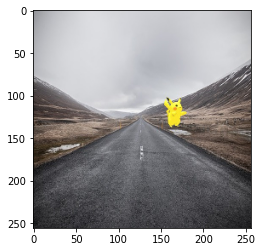

In [0]:
path = tf.strings.join([data_dir, "train", "images", "1.png"], separator='/')
img = tf.io.read_file(path)
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, dtype=tf.float32)
img = tf.image.resize(img, size=(256,256))
print(img.shape)
print(img[0][0])
plt.imshow(img)

然后我们通过创建DataLoader实例来读取目标检测数据集。我们将以随机顺序读取训练数据集，按序读取测试数据集。

*原书还做了数据增强: 对于训练集中的每张图像，我们将采用随机裁剪，并要求裁剪出的图像至少覆盖每个目标95%的区域。由于裁剪是随机的，这个要求不一定总被满足。我们设定最多尝试200次随机裁剪：如果都不符合要求则不裁剪图像。为保证输出结果的确定性，我们不随机裁剪测试数据集中的图像。 我们也无须按随机顺序读取测试数据集。*

In [0]:
def load_data_pikachu(batch_size, edge_size=256, data_dir="data/pikachu"):
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)

    def load_dataset(part):
        images, labels = generatorPikachuDataset(data_dir, part, image_size)

        dataset = tf.data.Dataset.from_tensor_slices((images, labels))
        dataset = dataset.shuffle(len(labels))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

    train_dataset = load_dataset("train")
    val_dataset = load_dataset("val")

    return train_dataset, val_dataset

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是pytorch(批量大小, 通道数, 高, 宽) tensorflow为（批量大小，高，宽，通道数）。而标签的形状则是(批量大小, m, 5)，其中m等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于mm的图像填充非法边界框，直到每张图像均含有m个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的xx和yy轴坐标以及右下角的xx和yy轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此m=1。

In [0]:
batch_size =  32
edge_size = 256

train_dataset, val_dataset = load_data_pikachu(batch_size, edge_size, data_dir)
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 5)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 256, 256, 3), (None, 5)), types: (tf.float32, tf.float32)>)

## 9.6.3 图示数据

我们画出10张图像和它们中的边界框。可以看到，皮卡丘的角度、大小和位置在每张图像中都不一样。当然，这是一个简单的人工数据集。实际中的数据通常会复杂得多。

In [0]:
item = next(iter(train_dataset))
print(item[0].numpy().shape, item[1].numpy().shape)

(32, 256, 256, 3) (32, 5)


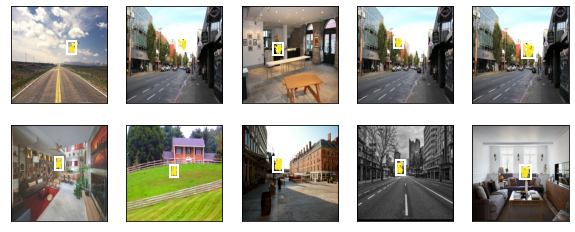

In [0]:
imgs = item[0][0:10]
bboxes = item[1][0:10, 1:]

axes = show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    show_bboxes(ax, [bb*edge_size], colors=['w'])

## 小结

* 合成的皮卡丘数据集可用于测试目标检测模型。
* 目标检测的数据读取跟图像分类的类似。然而，在引入边界框后，标签形状和图像增广（如随机裁剪）发生了变化。